# Import thư viện

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


# CatBoost

# Load data

In [2]:
df = pd.read_csv("../Data/processed.csv")
df.sample()

,street_name,price,area,air_conditioning,fridge,washing_machine,mezzanine,kitchen,wardrobe,bed,...,parking,month,district,price_per_m2,latitude,longitude,dist_to_q1_km,district_median_price,is_hot_street,amenity_ratio
14911,Huỳnh Văn Nghệ,3.5,25.0,0,0,0,1,1,0,0,...,1,7,Quận Tân Bình,0.14,10.803093,106.652352,6.012419,4.0,0,0.545455


# Data Preparation

In [ ]:
q_low = df["price"].quantile(0.05)
# q_high = df["price"].quantile(0.95)

df = df[(df["price"] > q_low) & (df["price"] < 20)]           

X = df.drop(columns=["price","price_per_m2"])
y = df['price']    
cat_features = ['street_name', 'district', 'month']


# Splitting Train/Validation/Test

In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)


X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, 
    test_size=0.5, 
    random_state=42
)

print(f"1. Tập Train (Huấn luyện): {X_train.shape[0]} dòng")
print(f"2. Tập Val (Tinh chỉnh/Early Stop): {X_val.shape[0]} dòng")
print(f"3. Tập Test (Chấm điểm độc lập): {X_test.shape[0]} dòng")

1. Tập Train (Huấn luyện): 13897 dòng
2. Tập Val (Tinh chỉnh/Early Stop): 2978 dòng
3. Tập Test (Chấm điểm độc lập): 2978 dòng


# Training

In [5]:
# Cell 5
# Khởi tạo mô hình
model = CatBoostRegressor(
    iterations=5000,           
    learning_rate=0.05,        
    depth=7,                   
    loss_function='RMSE',      
    eval_metric='RMSE',        
    random_seed=42,
    verbose=100         ,
    allow_writing_files=False    
)

#
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val), 
    early_stopping_rounds=75
)

0:	learn: 1.2677364	test: 1.2538744	best: 1.2538744 (0)	total: 130ms	remaining: 10m 49s
100:	learn: 0.9620615	test: 0.9715452	best: 0.9715452 (100)	total: 2.88s	remaining: 2m 19s
200:	learn: 0.9350158	test: 0.9674838	best: 0.9672379 (183)	total: 5.56s	remaining: 2m 12s
300:	learn: 0.9153215	test: 0.9655187	best: 0.9654622 (299)	total: 8.05s	remaining: 2m 5s
400:	learn: 0.8980934	test: 0.9652918	best: 0.9645957 (333)	total: 10.6s	remaining: 2m 1s
Stopped by overfitting detector  (75 iterations wait)

bestTest = 0.9645957486
bestIteration = 333

Shrink model to first 334 iterations.


# Evaluation

Dataset      | RMSE     | MAE      | R2 Score
---------------------------------------------
TRAIN        | 0.9173   | 0.6514   | 0.4947
VALIDATION   | 0.9646   | 0.6906   | 0.4292
TEST         | 0.9468   | 0.6740   | 0.4288


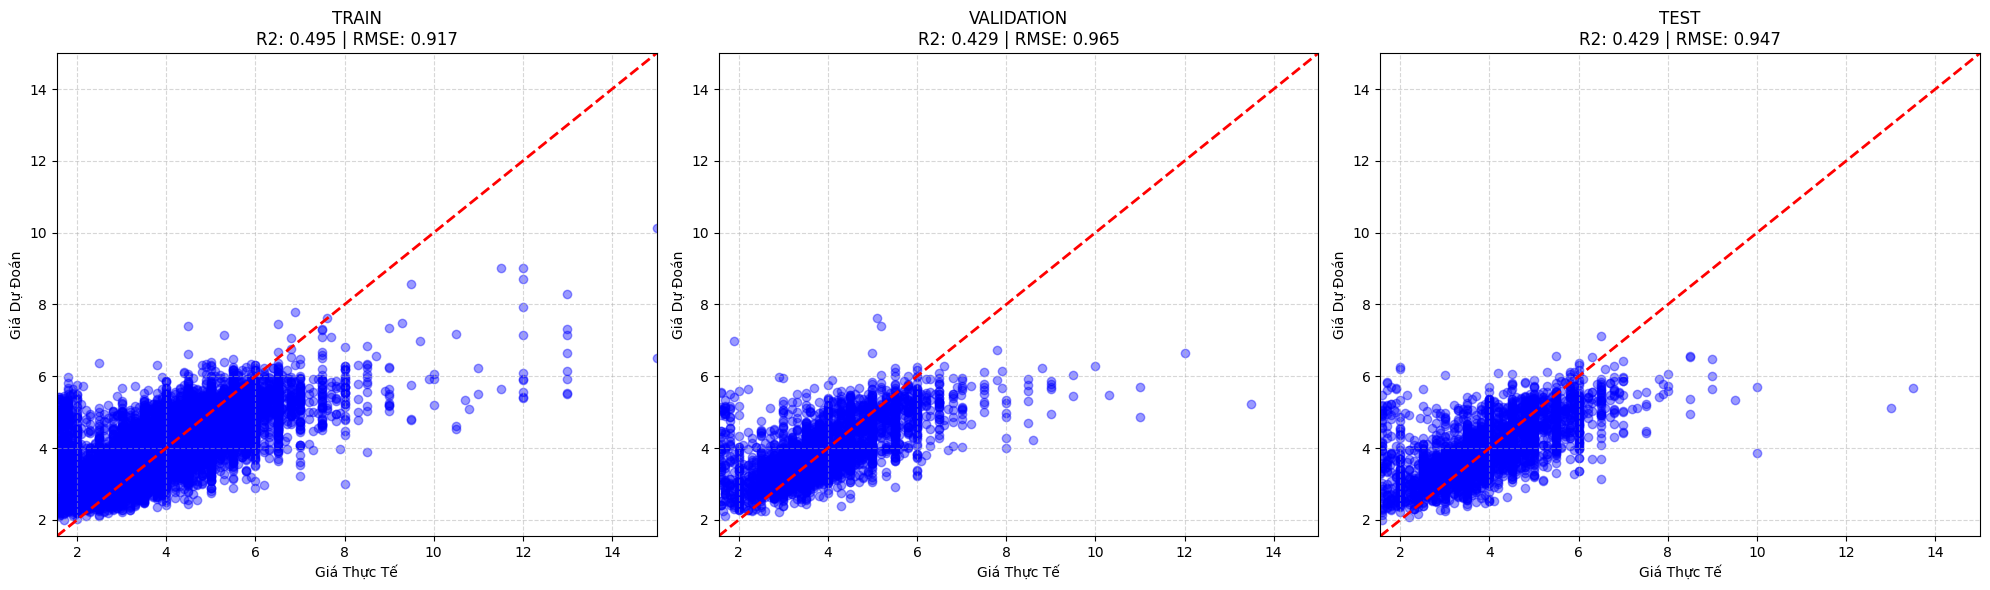

In [6]:

def evaluate_model(model, X, y, dataset_name):
    pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    mae = mean_absolute_error(y, pred)
    return pred, rmse, r2, mae

datasets = {
    "TRAIN": (X_train, y_train),
    "VALIDATION": (X_val, y_val),
    "TEST": (X_test, y_test)
}

results = {}
print(f"{'Dataset':<12} | {'RMSE':<8} | {'MAE':<8} | {'R2 Score':<8}")
print("-" * 45)

for name, (X_part, y_part) in datasets.items():
    pred, rmse, r2, mae = evaluate_model(model, X_part, y_part, name)
    results[name] = {"y_true": y_part, "y_pred": pred, "rmse": rmse, "r2": r2}
    print(f"{name:<12} | {rmse:.4f}   | {mae:.4f}   | {r2:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

global_min = y_train.min()
global_max = y_train.max()

for i, (name, data) in enumerate(results.items()):
    ax = axes[i]
    ax.scatter(data["y_true"], data["y_pred"], alpha=0.4, color='blue')
    
    ax.plot([global_min, global_max], [global_min, global_max], 'r--', lw=2)
    
    ax.set_title(f'{name}\nR2: {data["r2"]:.3f} | RMSE: {data["rmse"]:.3f}')
    ax.set_xlabel('Giá Thực Tế')
    ax.set_ylabel('Giá Dự Đoán')
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(global_min, global_max)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Feature Importance

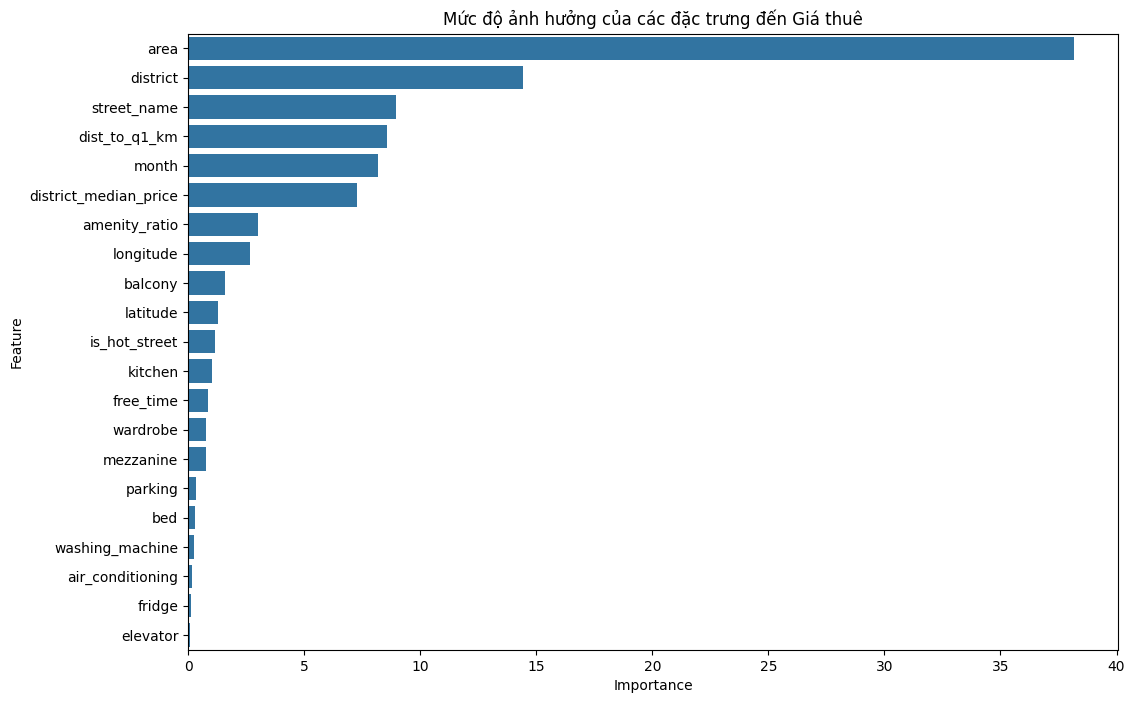

In [ ]:
feature_importance = model.get_feature_importance()
feature_names = X.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Mức độ ảnh hưởng của các đặc trưng đến Giá thuê')
plt.show()